# load libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load and Clean the Dataset

In [51]:
df=pd.read_csv("C:/Users/D.Sathiya Pandi/Downloads/tesla_stock_data_2000_2025.csv")
df.head(3)

,Price,Close,High,Low,Open,Volume
0,Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-06-29,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500


In [52]:
df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

In [53]:
df = df.iloc[2:].reset_index(drop=True)

In [54]:
df.head(5)

,Date,Close,High,Low,Open,Volume
0,2010-06-29,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
1,2010-06-30,1.5886670351028442,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
2,2010-07-01,1.4639999866485596,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000
3,2010-07-02,1.2799999713897705,1.5399999618530273,1.24733304977417,1.5333329439163208,77097000
4,2010-07-06,1.0740000009536743,1.3333330154418945,1.0553330183029175,1.3333330154418945,103003500


 # LSTM 

In [55]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Select 'Close' column
data = df[['Close']].values

# Normalize between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences (look back 60 days to predict next day)
X, y = [], []
sequence_length = 60

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-Test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Build and Train the LSTM Model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
82/82 [==============================] - 23s 126ms/step - loss: 9.3569e-04 - val_loss: 0.0037
Epoch 2/10
82/82 [==============================] - 8s 91ms/step - loss: 1.1086e-04 - val_loss: 0.0060
Epoch 3/10
82/82 [==============================] - 7s 91ms/step - loss:

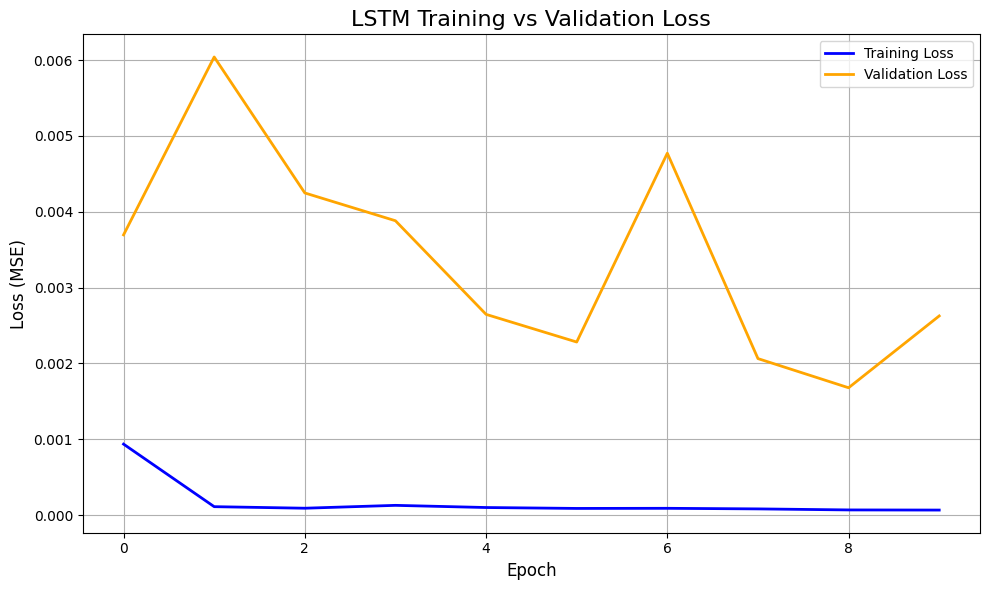

In [58]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title("LSTM Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ARIMA Model

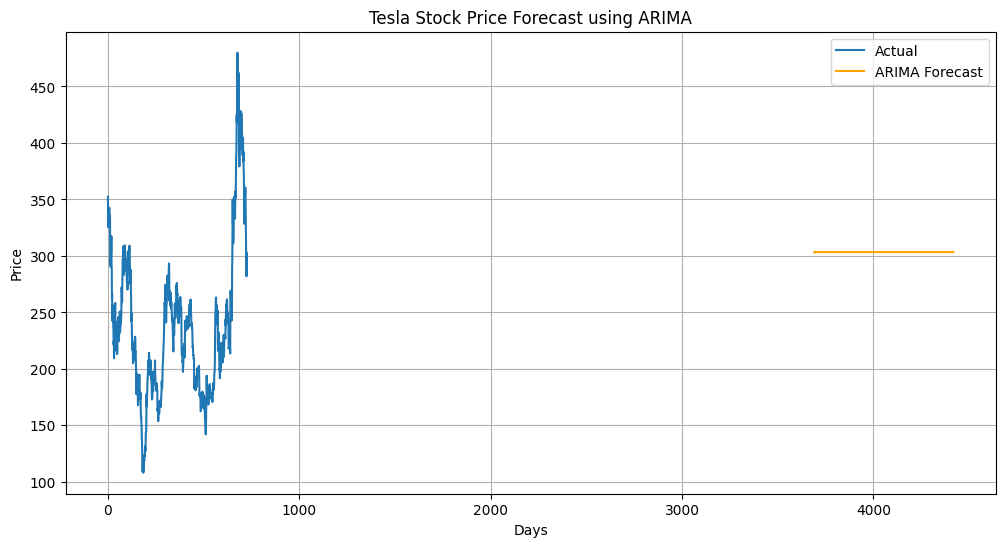

 ARIMA MAE: 82.6761, RMSE: 93.0193


In [59]:
from statsmodels.tsa.arima.model import ARIMA

# Drop NaN values just in case
arima_series = df['Close'].dropna().astype(float)

# Fit ARIMA model
model_arima = ARIMA(arima_series, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Forecast same length as LSTM test
forecast_arima = model_arima_fit.forecast(steps=len(y_test))

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_arima = mean_absolute_error(actual_prices.flatten(), forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(actual_prices.flatten(), forecast_arima))

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual')
plt.plot(forecast_arima, label='ARIMA Forecast', color='orange')
plt.title("Tesla Stock Price Forecast using ARIMA")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

print(f" ARIMA MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}")


# SARIMA MODEL

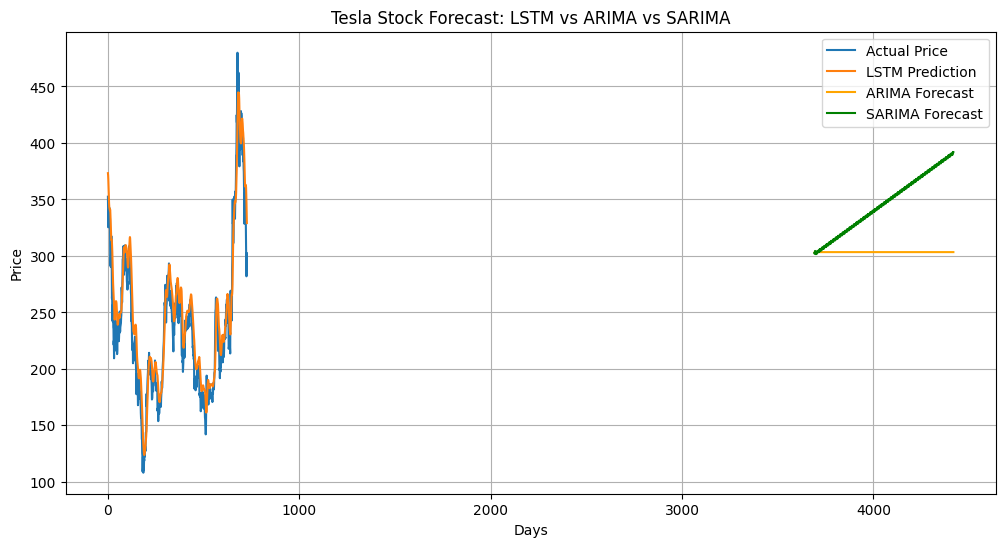

SARIMA MAE: 112.9938, RMSE: 126.3648


In [60]:

# SARIMA model 
sarima_model = SARIMAX(arima_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# Forecast same length as LSTM test
forecast_sarima = sarima_result.forecast(steps=len(y_test))

# Evaluate SARIMA
mae_sarima = mean_absolute_error(actual_prices.flatten(), forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(actual_prices.flatten(), forecast_sarima))

# Plot SARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='LSTM Prediction')
plt.plot(forecast_arima, label='ARIMA Forecast', color='orange')
plt.plot(forecast_sarima, label='SARIMA Forecast', color='green')
plt.title("Tesla Stock Forecast: LSTM vs ARIMA vs SARIMA")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Print evaluation
print(f"SARIMA MAE: {mae_sarima:.4f}, RMSE: {rmse_sarima:.4f}")


In [37]:
!pip install flask nest_asyncio pandas numpy matplotlib scikit-learn tensorflow statsmodels


Defaulting to user installation because normal site-packages is not writeable


In [41]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf

# Load dataset
df = pd.read_csv("C:/Users/D.Sathiya Pandi/Downloads/tesla_stock_data_2000_2025.csv")
df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
df = df.iloc[2:].reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df.dropna(inplace=True)
df.set_index("Date", inplace=True)

# Normalize data
data = df[['Close']].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare sequences for LSTM
X, y = [], []
sequence_length = 60
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X).reshape(-1, sequence_length, 1)
y = np.array(y)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

lstm_pred = model.predict(X_test)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

mae_lstm = mean_absolute_error(actual_prices, lstm_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(actual_prices, lstm_pred_inv))

# ARIMA
arima_series = df['Close'].astype(float)
model_arima = ARIMA(arima_series, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(y_test))
mae_arima = mean_absolute_error(actual_prices.flatten(), forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(actual_prices.flatten(), forecast_arima))

# SARIMA
model_sarima = SARIMAX(arima_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.forecast(steps=len(y_test))
mae_sarima = mean_absolute_error(actual_prices.flatten(), forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(actual_prices.flatten(), forecast_sarima))

# Save all outputs
with open("forecast_results.pkl", "wb") as f:
    pickle.dump({
        "actual": actual_prices,
        "lstm": lstm_pred_inv,
        "arima": forecast_arima,
        "sarima": forecast_sarima,
        "mae_lstm": mae_lstm,
        "rmse_lstm": rmse_lstm,
        "mae_arima": mae_arima,
        "rmse_arima": rmse_arima,
        "mae_sarima": mae_sarima,
        "rmse_sarima": rmse_sarima
    }, f)


Epoch 1/5
91/91 [==============================] - 20s 84ms/step - loss: 0.0019
Epoch 2/5
91/91 [==============================] - 8s 86ms/step - loss: 3.6061e-04
Epoch 3/5
91/91 [==============================] - 8s 87ms/step - loss: 3.9246e-04
Epoch 4/5
91/91 [==============================] - 8s 87ms/step - loss: 2.9425e-04
Epoch 5/5
23/23 [==============================] - 3s 33ms/step


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\P

In [42]:
from flask import Flask, render_template_string
import pickle
import matplotlib.pyplot as plt
import io
import base64
import nest_asyncio
nest_asyncio.apply()

app = Flask(__name__)

HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head><title>Tesla Forecast Dashboard</title></head>
<body style="font-family: Arial; text-align: center; background: #f2f2f2;">
    <h1>📈 Tesla Stock Forecast using LSTM, ARIMA, SARIMA</h1>
    <img src="data:image/png;base64,{{ plot_img }}" style="max-width:90%">
    <div style="background:white; padding:20px; margin:20px auto; border-radius:10px; width:60%; box-shadow:0 0 10px #ccc;">
        <h2>📊 Evaluation Metrics</h2>
        <p><strong>LSTM MAE:</strong> {{ mae_lstm }} | <strong>RMSE:</strong> {{ rmse_lstm }}</p>
        <p><strong>ARIMA MAE:</strong> {{ mae_arima }} | <strong>RMSE:</strong> {{ rmse_arima }}</p>
        <p><strong>SARIMA MAE:</strong> {{ mae_sarima }} | <strong>RMSE:</strong> {{ rmse_sarima }}</p>
    </div>
</body>
</html>
"""

@app.route('/')
def show_dashboard():
    with open("forecast_results.pkl", "rb") as f:
        data = pickle.load(f)

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data["actual"], label="Actual", color="black")
    ax.plot(data["lstm"], label="LSTM", color="blue")
    ax.plot(data["arima"], label="ARIMA", color="orange")
    ax.plot(data["sarima"], label="SARIMA", color="green")
    ax.set_title("Tesla Stock Forecast (Test Set)")
    ax.legend()
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plot_img = base64.b64encode(buf.read()).decode()

    return render_template_string(HTML_TEMPLATE,
                                  plot_img=plot_img,
                                  mae_lstm=f"{data['mae_lstm']:.4f}",
                                  rmse_lstm=f"{data['rmse_lstm']:.4f}",
                                  mae_arima=f"{data['mae_arima']:.4f}",
                                  rmse_arima=f"{data['rmse_arima']:.4f}",
                                  mae_sarima=f"{data['mae_sarima']:.4f}",
                                  rmse_sarima=f"{data['rmse_sarima']:.4f}"
                                  )

app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [22/Jun/2025 21:51:06] "GET / HTTP/1.1" 200 -
